<a href="https://colab.research.google.com/github/andythetechnerd03/PyTorch_Learning/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#08. PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn an ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transform (ViT) paper with PyTorch.

## 0. Get setup

Let's import required code + libraries

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 32.98 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steak, sushi images we've seen so far.

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

Setup the training and testing directories

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

Now we've got some data, let's now turn in into `DataLoader`s

To do so we can use the `create_dataloaders()` function in `data_setup.py`.

First, we'll create a transform to prepare our images.

This where one of the forst references to the ViT paper will come in.

### 2.1. Prepare transforms for images

In [6]:
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224 # comes from the table 3 of the paper

# create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print("Manually created transforms:", manual_transforms)

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2. Turn data into DataLoaders

In [7]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir, test_dir, batch_size=BATCH_SIZE, transform=manual_transforms
)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3. Visualize a single image

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([3, 224, 224]), tensor(2))

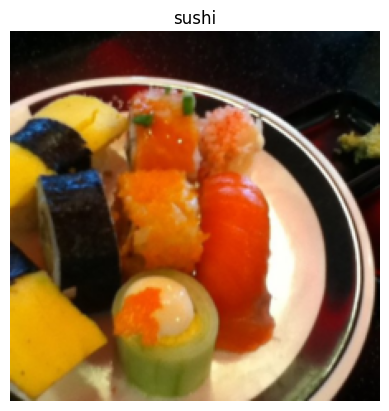

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be intimidating.

So in order to make it more understandable, we break it down to small pieces:

* **Inputs**: What goes nto the model? (in our case, image tensors)
* **Outputs**: What comes out of the model/layer/block? (In our case, we want the model to output image classification labels)
* **Layers** - takes an input, manipulates it with a function (for example could be self-attention)
* **Blocks** - A collection of layers.
* **Model** - A collection of blocks.

### 3.1. ViT overview: pieces of the puzzle

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

### 4.1 Calculating patch embedding input and output shapes by hand¶


In [10]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the total number of patches
number_of_patches = height * width // patch_size**2
print(f"Number of patches (N) with image height {height} and width {width} and patch size {patch_size} is {number_of_patches}")

Number of patches (N) with image height 224 and width 224 and patch size 16 is 196


In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### 4.2. Turning a single image into patches

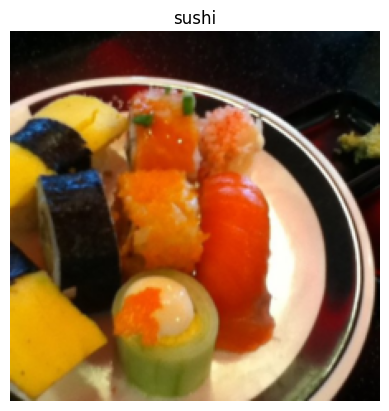

In [12]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

Let's look at the top row (first 16 pixel rows) first

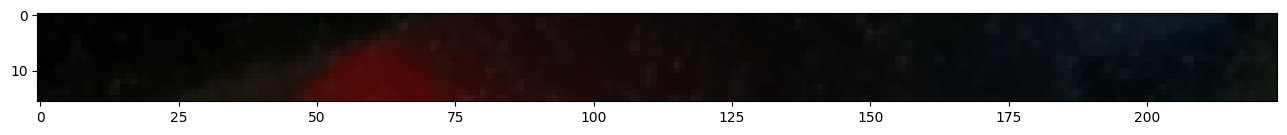

In [13]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


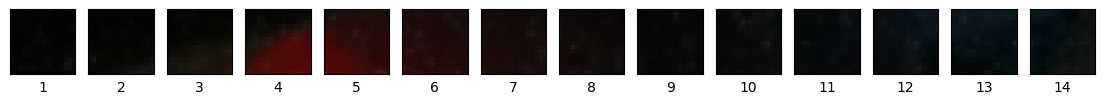

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


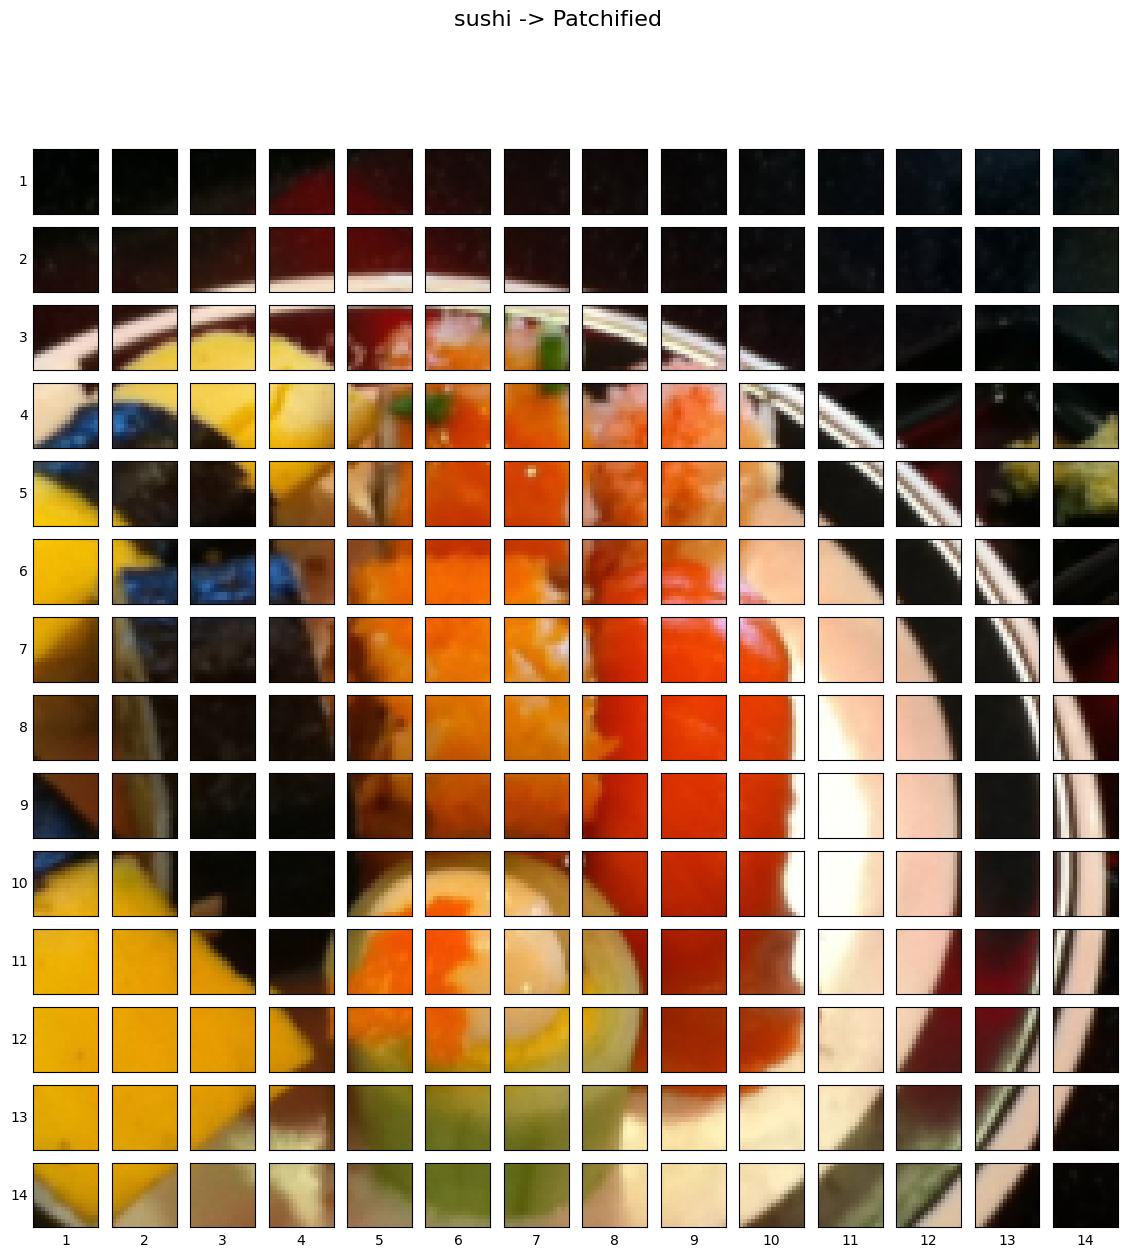

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  for j, patch1 in enumerate(range(0, img_size, patch_size)):
    axs[i][j].imshow(image_permuted[patch:patch+patch_size, patch1:patch1+patch_size, :]); # keep height index constant, alter the width index
    # Set up label information, remove the ticks for clarity and set labels to outside
    axs[i, j].set_ylabel(i+1,
                          rotation="horizontal",
                          horizontalalignment="right",
                          verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.3. Creating image patches using `Conv2d`

In [16]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

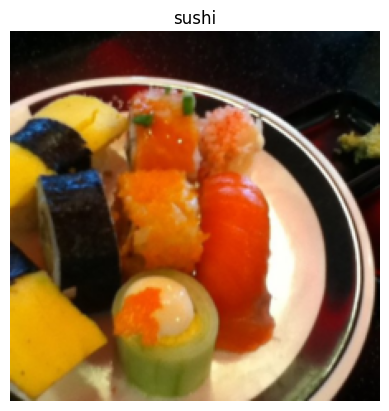

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [18]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


So its output shape can be read as:

```python
torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [455, 265, 741, 411, 271]


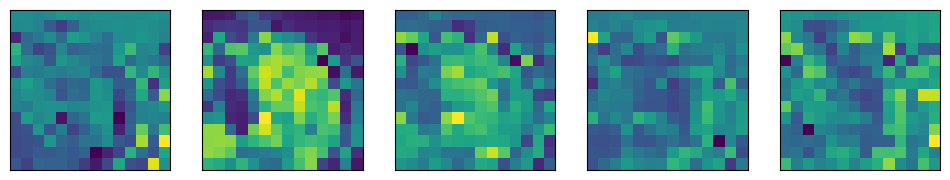

In [19]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [20]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0562,  0.0469,  0.0529,  0.1166,  0.1485,  0.1036,  0.0811,
            0.0796,  0.0597,  0.0656,  0.0556,  0.0875,  0.1057,  0.0730],
          [ 0.0836,  0.1076,  0.2490,  0.3604,  0.2981,  0.3672,  0.2620,
            0.1001,  0.0793,  0.0729,  0.0800,  0.0824,  0.0565,  0.0911],
          [-0.0553,  0.6165,  0.6904,  0.5372,  0.1742,  0.6632,  0.7102,
            0.3698,  0.4582,  0.2569,  0.0878,  0.0713,  0.0849,  0.0767],
          [ 0.8567,  0.4861,  0.7227,  0.7489,  0.6248,  0.4575,  0.5105,
            0.5016,  0.6919,  0.6438,  0.4619,  0.0634,  0.0463,  0.0975],
          [ 0.5666,  0.1934,  0.1086,  0.4629,  0.5335,  0.4512,  0.4080,
            0.4238,  0.5280,  0.6596,  0.2296,  0.6458,  0.1629,  0.2759],
          [ 0.7121,  0.4180,  0.0158,  0.2580,  0.4397,  0.5008,  0.5633,
            0.3812,  0.4560,  0.7070,  0.8312,  0.1634,  0.7143,  0.0774],
          [ 0.5302,  0.3541,  0.1546,  0.1566,  0.4050,  0.5550,  0.5577,
            0.4556,  0.6542,  0.

### 4.4. Flattening the image patches using `torch.nn.Flatten()`

In [21]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [22]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


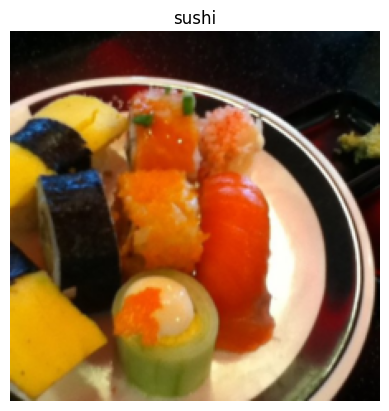

In [23]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Change the dimension to match the paper's output shape

In [24]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


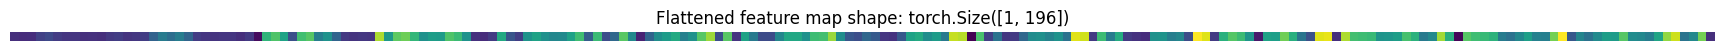

In [25]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [26]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.0562,  0.0469,  0.0529,  0.1166,  0.1485,  0.1036,  0.0811,  0.0796,
           0.0597,  0.0656,  0.0556,  0.0875,  0.1057,  0.0730,  0.0836,  0.1076,
           0.2490,  0.3604,  0.2981,  0.3672,  0.2620,  0.1001,  0.0793,  0.0729,
           0.0800,  0.0824,  0.0565,  0.0911, -0.0553,  0.6165,  0.6904,  0.5372,
           0.1742,  0.6632,  0.7102,  0.3698,  0.4582,  0.2569,  0.0878,  0.0713,
           0.0849,  0.0767,  0.8567,  0.4861,  0.7227,  0.7489,  0.6248,  0.4575,
           0.5105,  0.5016,  0.6919,  0.6438,  0.4619,  0.0634,  0.0463,  0.0975,
           0.5666,  0.1934,  0.1086,  0.4629,  0.5335,  0.4512,  0.4080,  0.4238,
           0.5280,  0.6596,  0.2296,  0.6458,  0.1629,  0.2759,  0.7121,  0.4180,
           0.0158,  0.2580,  0.4397,  0.5008,  0.5633,  0.3812,  0.4560,  0.7070,
           0.8312,  0.1634,  0.7143,  0.0774,  0.5302,  0.3541,  0.1546,  0.1566,
           0.4050,  0.5550,  0.5577,  0.4556,  0.6542,  0.6648,  0.8269,  0.4392,
           0.202

### 4.5. Turning the ViT embedding layer into PyTorch Module

In [27]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()

    self.patch_size = patch_size

    # create a layer to turn images to patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # flatten layer to flatten feature map of convolution
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    # create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch_size, image_shape: {image_resolution}, patch_size: {self.patch_size}"

    # perform forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # change the order dimension to num_patches x embed_dim
    return x_flattened.permute(0,2,1)

In [28]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [29]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 4.6. Creating the class token enbedding

In [30]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.0401, -0.0100, -0.0392,  ...,  0.0325, -0.0079,  0.0180],
         [-0.0595, -0.0067, -0.0510,  ...,  0.0248, -0.0055,  0.0226],
         [-0.0726, -0.0081, -0.0548,  ...,  0.0661, -0.0313,  0.0367],
         ...,
         [-0.6314,  0.1208, -0.2373,  ...,  0.4329, -0.2400,  0.1630],
         [-0.4423, -0.0585, -0.0581,  ...,  0.1002, -0.0822,  0.4985],
         [-0.0403, -0.0031, -0.0240,  ...,  0.0272, -0.0169,  0.0047]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]



To "prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding in the shape of the embedding_dimension (
D
 ) and then add it to the number_of_patches dimension.

Or in pseudocode:

patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
Notice the concatenation (torch.cat()) happens on dim=1 (the number_of_patches dimension).

Let's create a learnable embedding for the class token.

To do so, we'll get the batch size and embedding dimension shape and then we'll create a torch.ones() tensor in the shape [batch_size, 1, embedding_dimension].

And we'll make the tensor learnable by passing it to nn.Parameter() with requires_grad=True.

In [31]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [32]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0401, -0.0100, -0.0392,  ...,  0.0325, -0.0079,  0.0180],
         [-0.0595, -0.0067, -0.0510,  ...,  0.0248, -0.0055,  0.0226],
         ...,
         [-0.6314,  0.1208, -0.2373,  ...,  0.4329, -0.2400,  0.1630],
         [-0.4423, -0.0585, -0.0581,  ...,  0.1002, -0.0822,  0.4985],
         [-0.0403, -0.0031, -0.0240,  ...,  0.0272, -0.0169,  0.0047]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.7. Creating the position embedding

In [33]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0401, -0.0100, -0.0392,  ...,  0.0325, -0.0079,  0.0180],
          [-0.0595, -0.0067, -0.0510,  ...,  0.0248, -0.0055,  0.0226],
          ...,
          [-0.6314,  0.1208, -0.2373,  ...,  0.4329, -0.2400,  0.1630],
          [-0.4423, -0.0585, -0.0581,  ...,  0.1002, -0.0822,  0.4985],
          [-0.0403, -0.0031, -0.0240,  ...,  0.0272, -0.0169,  0.0047]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [34]:
# calculate N (number_of_patches)

number_of_patches = (height*width)//patch_size**2

# get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [35]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding, patch_and_position_embedding.shape)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9599, 0.9900, 0.9608,  ..., 1.0325, 0.9921, 1.0180],
         [0.9405, 0.9933, 0.9490,  ..., 1.0248, 0.9945, 1.0226],
         ...,
         [0.3686, 1.1208, 0.7627,  ..., 1.4329, 0.7600, 1.1630],
         [0.5577, 0.9415, 0.9419,  ..., 1.1002, 0.9178, 1.4985],
         [0.9597, 0.9969, 0.9760,  ..., 1.0272, 0.9831, 1.0047]]],
       grad_fn=<AddBackward0>) torch.Size([1, 197, 768])


### 4.8. Putting it all together: from image to embedding

In [36]:
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get the image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding),
                                        dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = height*width // patch_size**2
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class_token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


Integrating everything into one Module

In [37]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()

    self.patch_size = patch_size

    # create a layer to turn images to patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # flatten layer to flatten feature map of convolution
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    # create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch_size, image_shape: {image_resolution}, patch_size: {self.patch_size}"

    # perform forward pass
    patch_embedding = self.flatten(self.patcher(x)).permute(0,2,1)
    # Create class token embedding
    batch_size = patch_embedding.shape[0]
    embedding_dimension = patch_embedding.shape[-1]
    class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                              requires_grad=True) # make sure it's learnable

    # Prepend the class token embedding to patch embedding
    patch_embedding_class_token = torch.cat((class_token, patch_embedding),
                                            dim=1)

    # Create position embedding
    number_of_patches = height*width // patch_size**2
    position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                      requires_grad=True)

    # Add the position embedding to patch embedding with class_token
    patch_and_position_embedding = patch_embedding_class_token + position_embedding
    return patch_and_position_embedding

In [38]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 197, 768])


## 5. Equation 2: Multi-Head Attention (MSA)

In [39]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA block" for short)
  """
  def __init__(self,
               embed_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 of ViT-Base
               attn_dropout:float=0): # doesn't look lik the paper uses any dropout
    super().__init__()
    # 3. Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)
    # 4. Create the Multi-head Attention (MSA) layer
    self.mha = nn.MultiheadAttention(embed_dim=embed_dim,
                                     num_heads=num_heads,
                                     dropout=attn_dropout,
                                     batch_first=True)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.mha(query=x,
                              key=x,
                              value=x,
                              need_weights=False)
    return attn_output


In [40]:
# Create an instance of MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embed_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP)

In [41]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
  """Creates a layer normalized multilayer perceptron block."""
  # 2. Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:float=0.1):
    super().__init__()

    # 3. Create the Norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # 4. Create the Multilayer Perceptron (MLP) layers
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  # 5. Create a forward() method to pass the data through the layers
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [42]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## 7. Create the Transformer Encoder

The Transformer Encoder is a combination of alnernating blocks of MSA and MLP.

And there are residual connections between blocks.

### 7.1. Creating a Transformer Encoder by combining our custom made layers

In [43]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:float=0.1,
               attn_dropout:float=0):
    super().__init__()

    # Create MSA Block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embed_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # Create MLP Block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual_connection
    x = self.mlp_block(x) + x # residial connection
    return x

In [44]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (mha)                    --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2. Creating a Transformer Encoder with PyTorch's Transformer layers

We can use PyTorch's built-in layers as well.

In [45]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [46]:
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

The output of the summary is slightly different to ours due to how torch.nn.TransformerEncoderLayer() constructs its layer.

But the layers it uses, number of parameters and input and output shapes are the same.

You might be thinking, "if we could create the Transformer Encoder so quickly with PyTorch layers, why did we bother reproducing equation 2 and 3?"

The answer is: practice.

Now we've replicated a series of equations and layers from a paper, if you need to change the layers and try something different you can.

But there are benefits of using the PyTorch pre-built layers, such as:

  * Less prone to errors - Generally, if a layer makes it into the PyTorch standard library, its been tested and tried to work.
  * Potentially better performance - As of July 2022 and PyTorch 1.12, the PyTorch implemented version of torch.nn.TransformerEncoderLayer() can see a speedup of more than 2x on many common workloads.

Finally, since the ViT architecture uses several Transformer Layers stacked on top of each for the full architecture (Table 1 shows 12 Layers in the case of ViT-Base), you can do this with torch.nn.TransformerEncoder(encoder_layer, num_layers) where:

  * encoder_layer - The target Transformer Encoder layer created with torch.nn.TransformerEncoderLayer().
  * num_layers - The number of Transformer Encoder layers to stack together.

## 8. Putting it alll together to create ViT

In [47]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768,
               embedding_dropout:float=0.1):
    super().__init__()

    self.patch_size = patch_size

    # create a layer to turn images to patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # flatten layer to flatten feature map of convolution
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    self.dropout = nn.Dropout(p=embedding_dropout)

  def forward(self, x):
    # create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch_size, image_shape: {image_resolution}, patch_size: {self.patch_size}"

    # perform forward pass
    patch_embedding = self.flatten(self.patcher(x)).permute(0,2,1)
    # Create class token embedding
    batch_size = patch_embedding.shape[0]
    embedding_dimension = patch_embedding.shape[-1]
    class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                              requires_grad=True) # make sure it's learnable

    # Prepend the class token embedding to patch embedding
    patch_embedding_class_token = torch.cat((class_token, patch_embedding),
                                            dim=1)

    # Create position embedding
    number_of_patches = image_resolution*image_resolution // self.patch_size**2
    position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                      requires_grad=True)

    # Add the position embedding to patch embedding with class_token
    patch_and_position_embedding = patch_embedding_class_token + position_embedding
    return self.dropout(patch_and_position_embedding)

In [48]:
# Create a ViT Class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224, # Table 3
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for ViT-Base
               embedding_dim:int=768, # Hidden size D from table 1 for ViT-Base
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:int=0,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1,
               num_classes:int=3):
    super().__init__()

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim,
                                          embedding_dropout=embedding_dropout)

    # Create the Transformer Encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                      num_heads=num_heads,
                                                                      mlp_size=mlp_size,
                                                                      mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
      x = self.patch_embedding(x)
      x = self.transformer_encoder(x)
      x = self.classifier(x[:,0]) # MLP Head
      return x

In [49]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [53]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224).to(device) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names)).to(device)

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument tensors in method wrapper_CUDA_cat)

### 8.1. Getting a visual summary of our ViT model

In [51]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Conv2d: 2, Flatten: 2]

## 9. Setting up training code for ViT model

### 9.1. Creating optimizer and loss function

Let's look at the paper and see what they used.

>Training & Fine-tuning. We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with  
β
1
=
0.9
,
β
2
=
0.999
 , a batch size of 4096 and apply a high weight decay of  
0.1
 , which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).
 >

 There's no information on loss function, so we use the familiar CrossEntropyLoss

In [56]:
from going_modular.going_modular import engine

# Setup the optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                            lr=3e-3,
                            betas=(0.9,0.999),
                            weight_decay=0.3)

# Setup the loss function
loss_fn = nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument tensors in method wrapper_CUDA_cat)

It's not very good 😞

### 9.4. What our training setup is missing

Hyperparameter value	ViT Paper	Our implementation
Number of training images	1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT)	225
Epochs	7 (for largest dataset), 90, 300 (for ImageNet)	10
Batch size	4096	32
Learning rate warmup	10k steps (Table 3)	None
Learning rate decay	Linear/Cosine (Table 3)	None
Gradient clipping	Global norm 1 (Table 3)	None

### 9.5. Plot the loss curves of our ViT model

In [ ]:
from helper functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

Very underfitting, it seems!

## 10. Using a pretrained ViT from `torchvision.models` on the same dataset

### 10.1. Why use a pretrained model?

An important note on many modern machine learning research papers is that much of the results are obtained with large datasets and vast compute resources.

And in modern day machine learning, the original fully trained ViT would likely not be considered a "super large" training setup (models are continually getting bigger and bigger).

Reading the ViT paper section 4.2:

Finally, the ViT-L/16 model pre-trained on the public ImageNet-21k dataset performs well on most datasets too, while taking fewer resources to pre-train: it could be trained using a standard cloud TPUv3 with 8 cores in approximately 30 days.

As of July 2022, the price for renting a TPUv3 (Tensor Processing Unit version 3) with 8 cores on Google Cloud is $8 USD per hour.

To rent one for 30 straight days would cost $5,760 USD.

This cost (monetary and time) may be viable for some larger research teams or enterprises but for many people it's not.

So having a pretrained model available through resources like torchvision.models, the timm (Torch Image Models) library, the HuggingFace Hub or even from the authors of the papers themselves (there's a growing trend for machine learning researchers to release the code and pretrained models from their research papers, I'm a big fan of this trend, many of these resources can be found on Paperswithcode.com).

If you're focused on leveraging the benefits of a specific model architecture rather than creating your custom architecture, I'd highly recommend using a pretrained model.

### 10.2. Getting a pretrained ViT model and creating a feature extractor

In [57]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


Setup device-agnostic code

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [70]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [71]:
# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### 10.3. Preparing data

Forget about it 😜

In [72]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [64]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [65]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [66]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


### 10.4. Train feature extractor ViT model

In [73]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5. Plot feature extractor ViT model loss curves

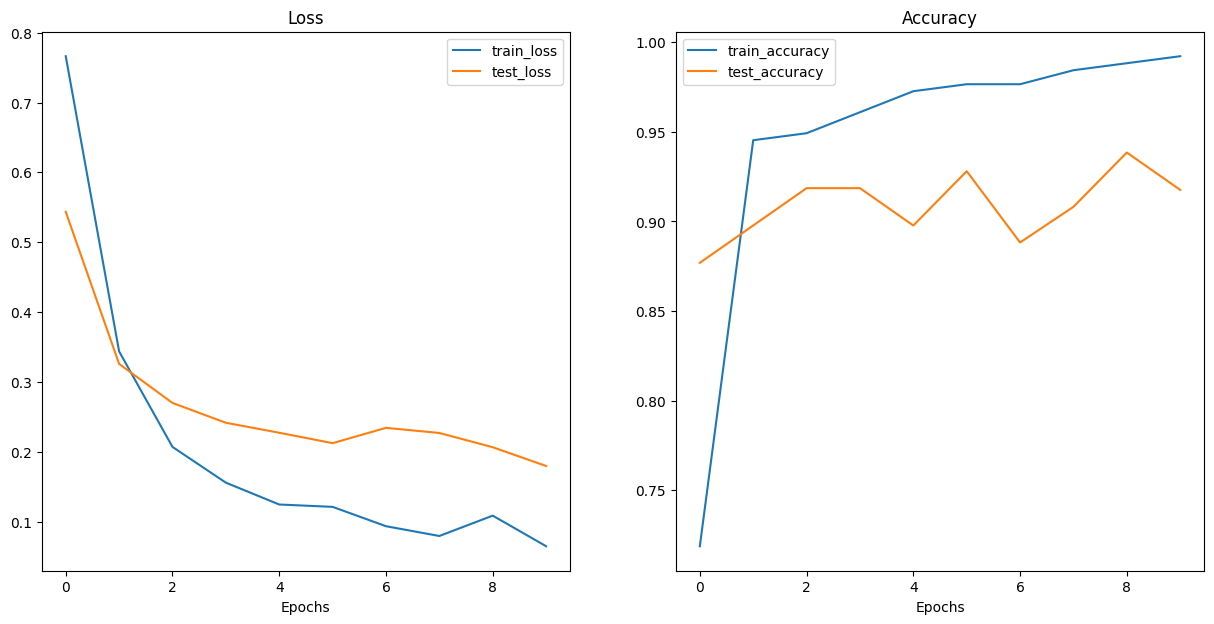

In [74]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6. Save feature extractor ViT model and check file size

In [75]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


Let's check out the size of the model.

In [76]:
from pathlib import Path

# get the model size in bytes then convert to megabytes
model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size / 1024 / 1024
print(f"Pretrained ViT feature extractor model size: {model_size:.2f} MB")

Pretrained ViT feature extractor model size: 327.37 MB


Hmm, looks like our ViT feature extractor model for Food Vision Mini turned out to be about 327 MB in size.

How does this compare to the EffNetB2 feature extractor model in 07. PyTorch Experiment Tracking section 9?

Model	Model size (MB)	Test loss	Test accuracy
EffNetB2 feature extractor^	29	~0.3906	~0.9384
ViT feature extractor	327	~0.1084	~0.9384
Note: ^ the EffNetB2 model in reference was trained with 20% of pizza, steak and sushi data (double the amount of images) rather than the ViT feature extractor which was trained with 10% of pizza, steak and sushi data. An exercise would be to train the ViT feature extractor model on the same amount of data and see how much the results improve.

The EffNetB2 model is ~11x smaller than the ViT model with similiar results for test loss and accuracy.

However, the ViT model's results may improve more when trained with the same data (20% pizza, steak and sushi data).

But in terms of deployment, if we were comparing these two models, something we'd need to consider is whether the extra accuracy from the ViT model is worth the ~11x increase in model size?

Perhaps such a large model would take longer to load/run and wouldn't provide as good an experience as EffNetB2 which performs similarly but at a much reduced size.

## 11. Make predictions on a custom image

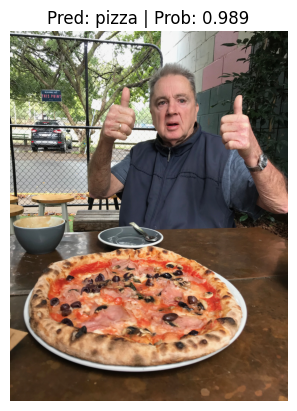

In [77]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)